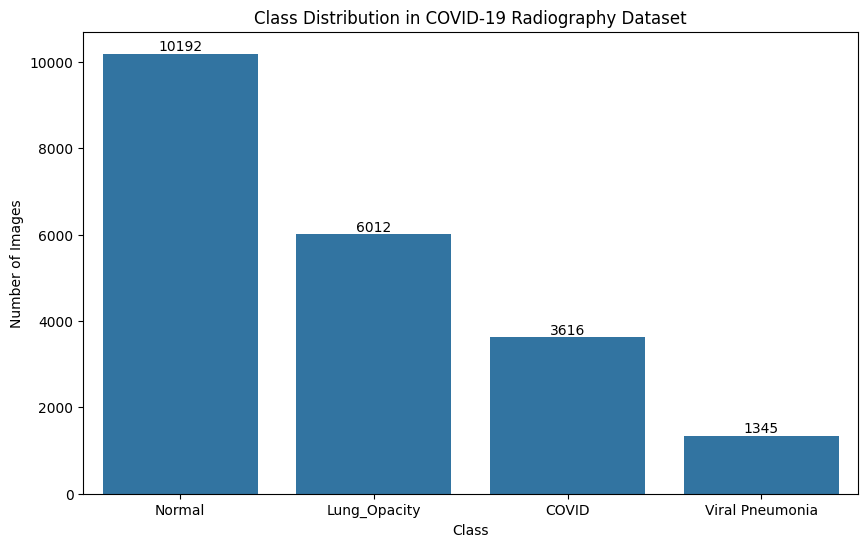

In [30]:
# Load the metadata, and check the class distribution in the dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_base_dir = './covid19-radiography-dataset/'
metadata = pd.read_csv(os.path.join(data_base_dir, 'metadata.csv'))

label_counts = metadata['label'].value_counts()
class_distribution = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Number of Images'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Number of Images', data=class_distribution)
plt.title('Class Distribution in COVID-19 Radiography Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# add counts to each bar
for i in range(class_distribution.shape[0]):
    count = class_distribution.iloc[i, 1]
    plt.text(i, count, count, ha='center', va='bottom')

plt.show()

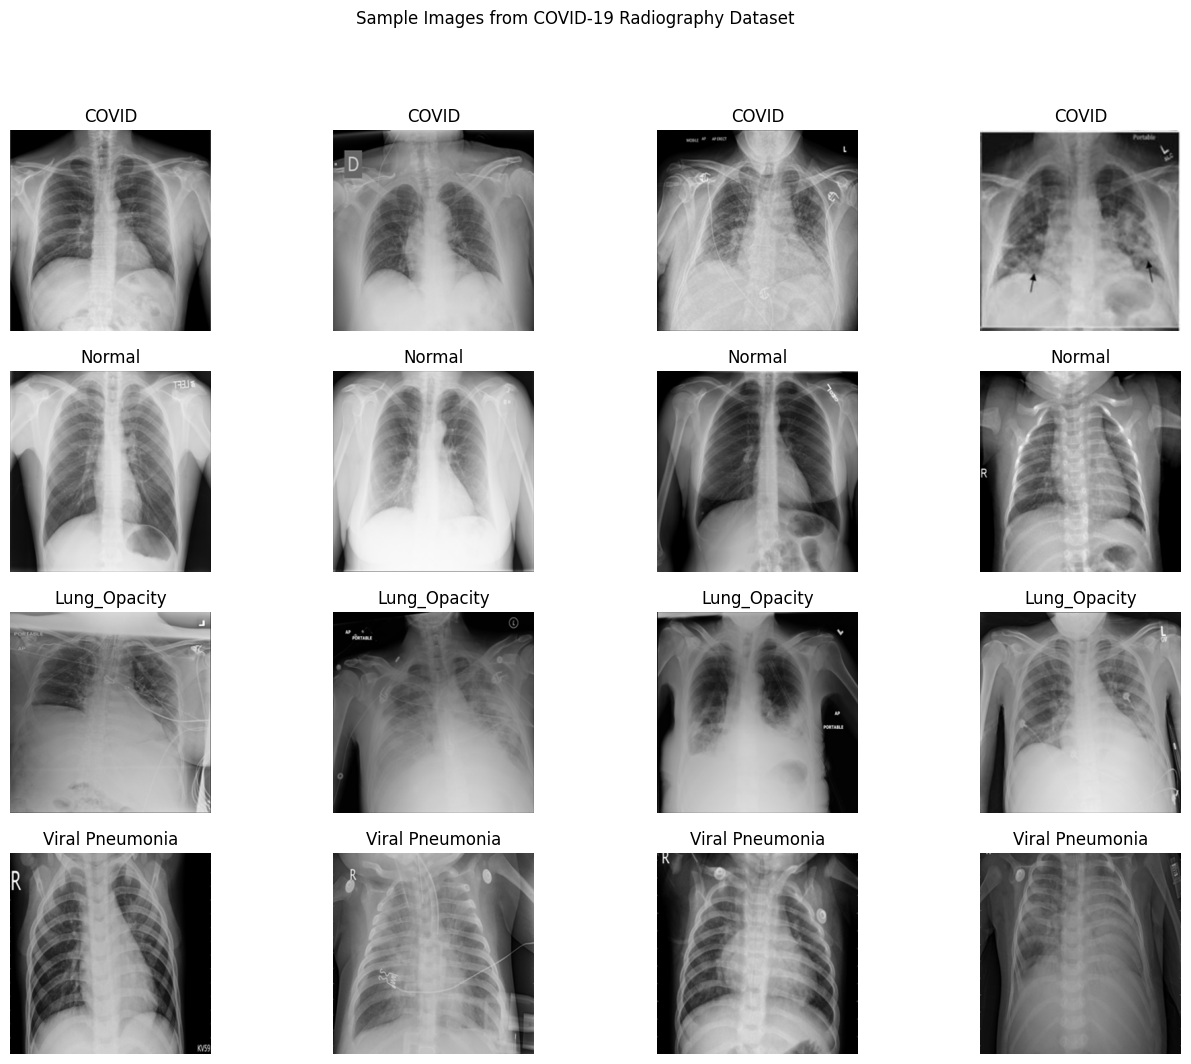

In [31]:
# Display sample images, randomly selected from the dataset

import cv2
import random
import os

radiography_dataset_path = os.path.join(data_base_dir, 'COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset')


def image_filename(image_id: int) -> str:
    """
        Return the filename of the image with the given image_id,
        using the relative base directory path.

        Args:
            image_id: The unique identifier of the image in the metadata

        Returns:
            The relative filename of the image
    """
    return os.path.join(radiography_dataset_path, metadata.loc[image_id, 'label'], metadata.loc[image_id, 'file_name'])


plt.figure(figsize=(16, 12))
# show 4 normal, 4 covid, 4 lung opacity, 4 viral pneumonia images
for i in ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']:
    class_images = metadata[metadata['label'] == i]
    random_indices = random.sample(range(class_images.shape[0]), 4)
    for j, idx in enumerate(random_indices):
        plt.subplot(4, 4, 4 * ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia'].index(i) + j + 1)
        image = cv2.imread(image_filename(class_images.index[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(i)
        plt.axis('off')

plt.suptitle('Sample Images from COVID-19 Radiography Dataset')
plt.show()

In [32]:
# Preprocess the images, ensuring all dimensions are the same (224x224)
# and check the class distribution again.
# Moving forwards we build a new dataframe to store the preprocessed images
# and fit the machine learning models to this new dataset.


def encode_labels(label: str) -> int:
    """
        Return the integer label for the given string label.

        Args:
            label: The string label

        Returns:
            The integer label
    """
    match label.casefold():
        case 'normal':
            return 0
        case 'covid':
            return 1
        case "lung_opacity":
            return 2
        case "viral pneumonia":
            return 3
        case _:
            raise ValueError(f'Invalid label: {label}')


def decode_labels(label: int) -> str:
    """
        Return the string label for the given integer label.

        Args:
            label: The integer label

        Returns:
            The string label
    """
    match label:
        case 0:
            return 'Normal'
        case 1:
            return 'COVID'
        case 2:
            return 'Lung_Opacity'
        case 3:
            return 'Viral Pneumonia'
        case _:
            raise ValueError(f'Invalid label: {label}')


df = pd.DataFrame(columns=['image', 'label'])

for i in metadata.index:
    filename = image_filename(i)
    label = metadata.loc[i, 'label']
    image = cv2.imread(filename)
    image = cv2.resize(image, (224, 224))
    image_flattened = image.flatten().astype(np.float32)

    label = encode_labels(label)
    df.loc[i] = {'image': image, 'label': label}

print(df.head())
print(df.shape)
print(df['label'].value_counts())

                                               image  label
0  [[[145, 145, 145], [18, 18, 18], [0, 0, 0], [0...      1
1  [[[134, 134, 134], [131, 131, 131], [129, 129,...      1
2  [[[49, 49, 49], [4, 4, 4], [0, 0, 0], [0, 0, 0...      1
3  [[[139, 139, 139], [139, 139, 139], [139, 139,...      1
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
(21165, 2)
label
0    10192
2     6012
1     3616
3     1345
Name: count, dtype: int64


In [33]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])

# Splitting the train data into train and validation sets
train, val = train_test_split(train, test_size=0.2, stratify=train['label'])

# Applying SMOTE to the training data
smote = SMOTE()
X_train_flattened = np.array(train['image'].tolist()).reshape(train.shape[0], -1)
y_train = train['label']
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape the resampled data back to the original shape
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 224, 224, 3)

# Splitting the resampled training data into train and validation sets if needed
X_train, X_val_smote, y_train, y_val_smote = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Prepare the testing data
X_test = np.array(test['image'].tolist(), dtype=np.float32).reshape(-1, 224, 224, 3)
y_test = test['label'].values

# Prepare the validation data
X_val = np.array(val['image'].tolist(), dtype=np.float32).reshape(-1, 224, 224, 3)
y_val = val['label'].values

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

print("Train set rebalanced class distribution:", pd.Series(y_train).value_counts())
print("Validation set class distribution:", pd.Series(y_val).value_counts())
print("Test set class distribution:", pd.Series(y_test).value_counts())

Train set shape: (23482, 224, 224, 3) (23482,)
Validation set shape: (3387, 224, 224, 3) (3387,)
Test set shape: (4233, 224, 224, 3) (4233,)
Train set class distribution: label
3    5926
2    5866
1    5846
0    5844
Name: count, dtype: int64


In [34]:
import tensorflow as tf

num_classes = len(np.unique(y_train))  # Number of classes

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Check shapes
print(y_train_categorical.shape, y_val_categorical.shape, y_test_categorical.shape)

(23482, 4) (3387, 4) (4233, 4)


In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model_resnet50.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)

Epoch 1/20
 83/734 ━━━━━━━━━━━━━━━━━━━━ 6:19 583ms/step - accuracy: 0.5992 - loss: 1.5659

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model for multi-class classification
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = model_vgg16.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)


Epoch 1/2
734/734 ━━━━━━━━━━━━━━━━━━━━ 1894s 3s/step - accuracy: 0.8091 - loss: 0.8073 - val_accuracy: 0.8736 - val_loss: 0.3240
Epoch 2/2
734/734 ━━━━━━━━━━━━━━━━━━━━ 3561s 5s/step - accuracy: 0.9163 - loss: 0.2284 - val_accuracy: 0.9203 - val_loss: 0.2248


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model for multi-class classification
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnet = model_efficientnet.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
734/734 ━━━━━━━━━━━━━━━━━━━━ 229s 306ms/step - accuracy: 0.8449 - loss: 0.3973 - val_accuracy: 0.9138 - val_loss: 0.2371
Epoch 2/2
734/734 ━━━━━━━━━━━━━━━━━━━━ 222s 302ms/step - accuracy: 0.9173 - loss: 0.2147 - val_accuracy: 0.9391 - val_loss: 0.1713


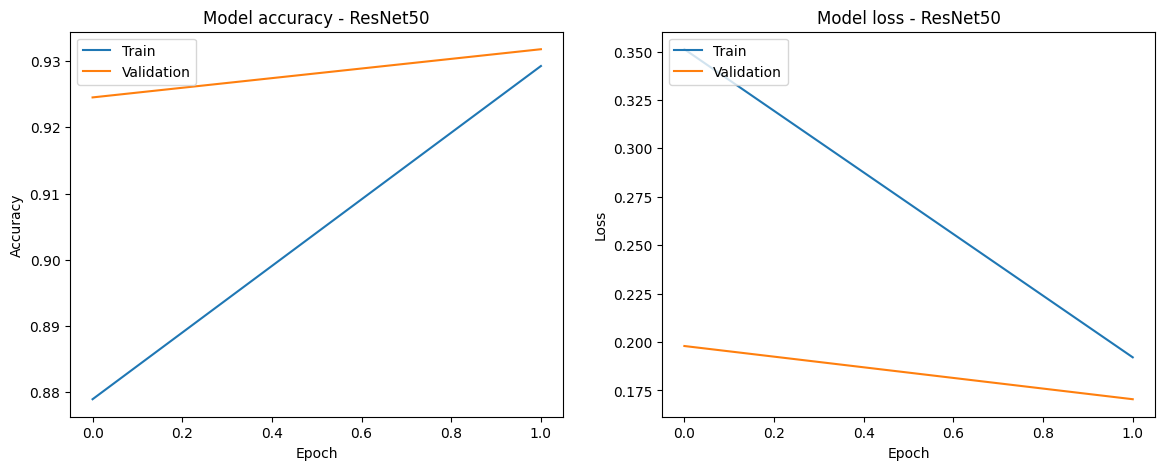

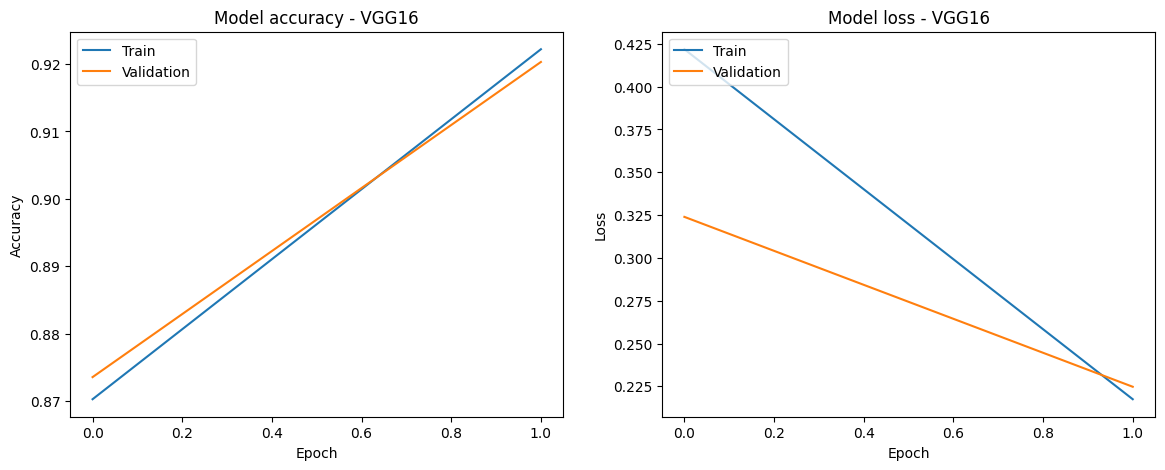

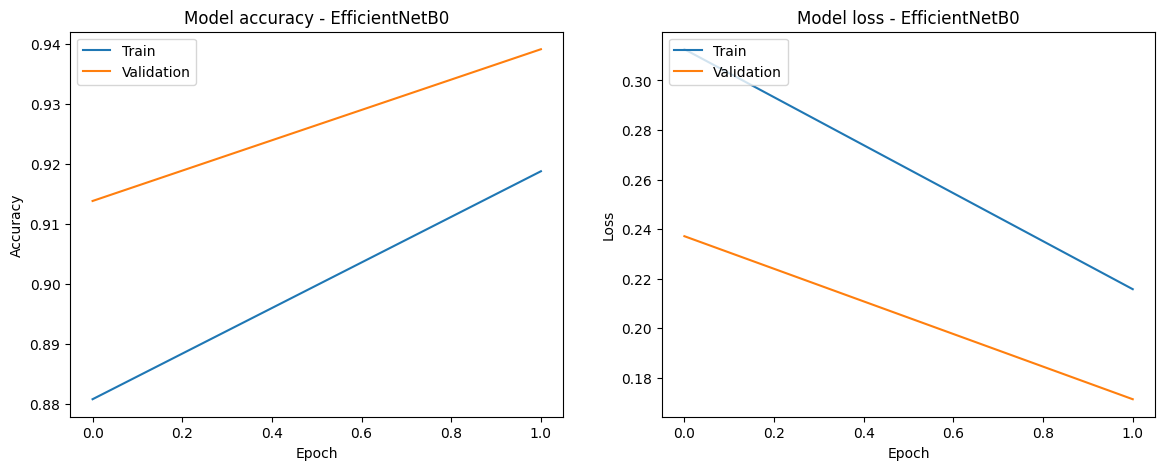

In [ ]:
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot history for ResNet50
plot_history(history_resnet50, 'ResNet50')

# Plot history for VGG16
plot_history(history_vgg16, 'VGG16')

# Plot history for EfficientNetB0
plot_history(history_efficientnet, 'EfficientNetB0')

133/133 ━━━━━━━━━━━━━━━━━━━━ 87s 649ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step


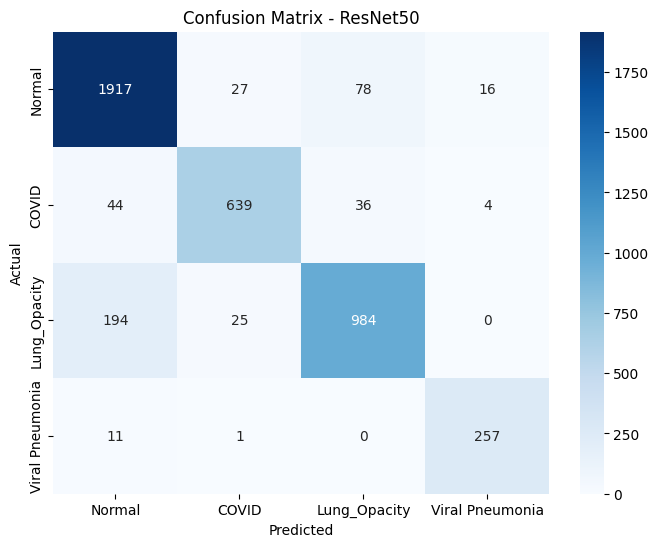

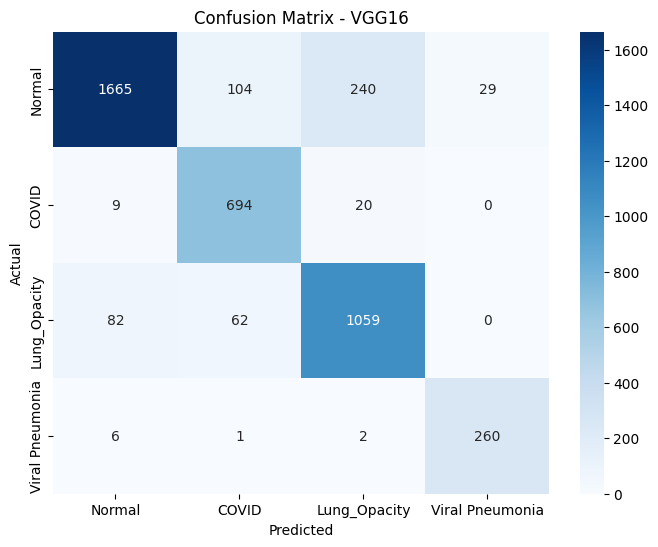

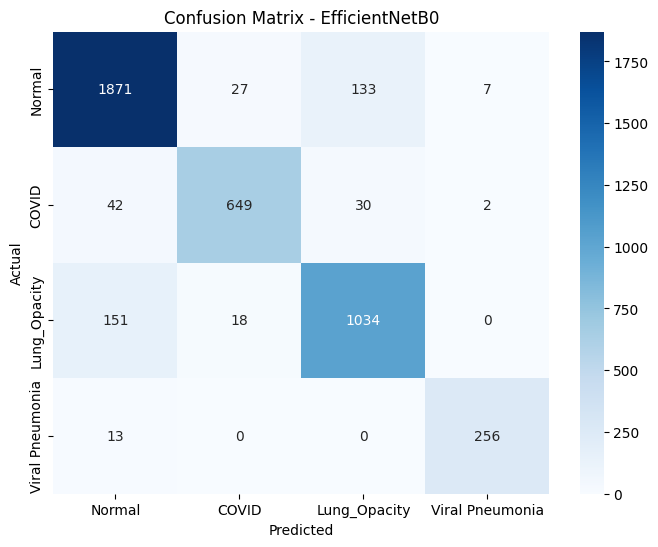

In [ ]:
# Confusion matrices for the models

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia'],
                yticklabels=['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Predictions for ResNet50
y_pred_resnet50 = model_resnet50.predict(X_test)
y_pred_resnet50 = np.argmax(y_pred_resnet50, axis=1)

# Predictions for VGG16
y_pred_vgg16 = model_vgg16.predict(X_test)
y_pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)

# Predictions for EfficientNetB0
y_pred_efficientnet = model_efficientnet.predict(X_test)
y_pred_efficientnet = np.argmax(y_pred_efficientnet, axis=1)

# Plot confusion matrix for ResNet50
plot_confusion_matrix(y_test, y_pred_resnet50, 'ResNet50')

# Plot confusion matrix for VGG16
plot_confusion_matrix(y_test, y_pred_vgg16, 'VGG16')

# Plot confusion matrix for EfficientNetB0
plot_confusion_matrix(y_test, y_pred_efficientnet, 'EfficientNetB0')


In [ ]:
# Classification report for the models

from sklearn.metrics import classification_report

# Classification report for ResNet50

print('Classification Report for ResNet50')
print(classification_report(y_test, y_pred_resnet50))

# Classification report for VGG16

print('Classification Report for VGG16')
print(classification_report(y_test, y_pred_vgg16))

# Classification report for EfficientNetB0

print('Classification Report for EfficientNetB0')
print(classification_report(y_test, y_pred_efficientnet))


Classification Report for ResNet50
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2038
           1       0.92      0.88      0.90       723
           2       0.90      0.82      0.86      1203
           3       0.93      0.96      0.94       269

    accuracy                           0.90      4233
   macro avg       0.91      0.90      0.90      4233
weighted avg       0.90      0.90      0.90      4233

Classification Report for VGG16
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2038
           1       0.81      0.96      0.88       723
           2       0.80      0.88      0.84      1203
           3       0.90      0.97      0.93       269

    accuracy                           0.87      4233
   macro avg       0.86      0.91      0.88      4233
weighted avg       0.88      0.87      0.87      4233

Classification Report for EfficientNetB0
              precisio

133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 642ms/step


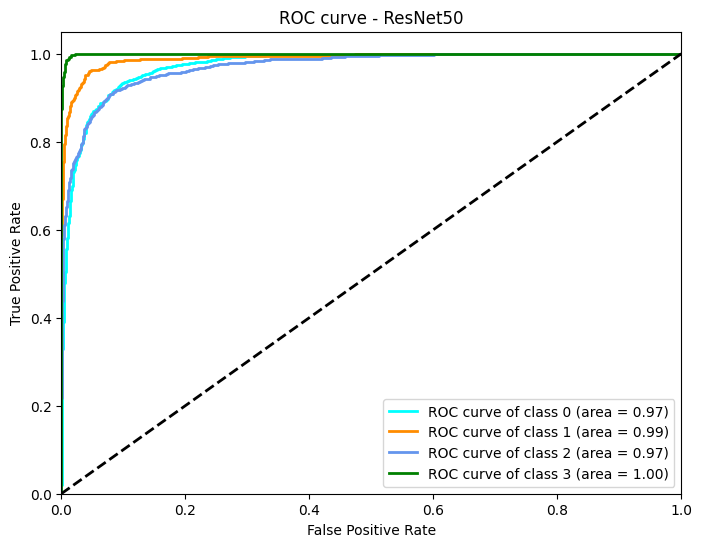

133/133 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step


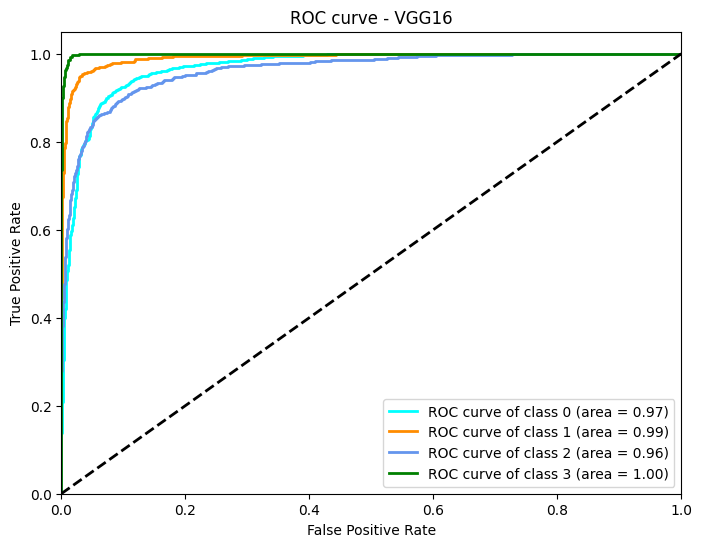

133/133 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step


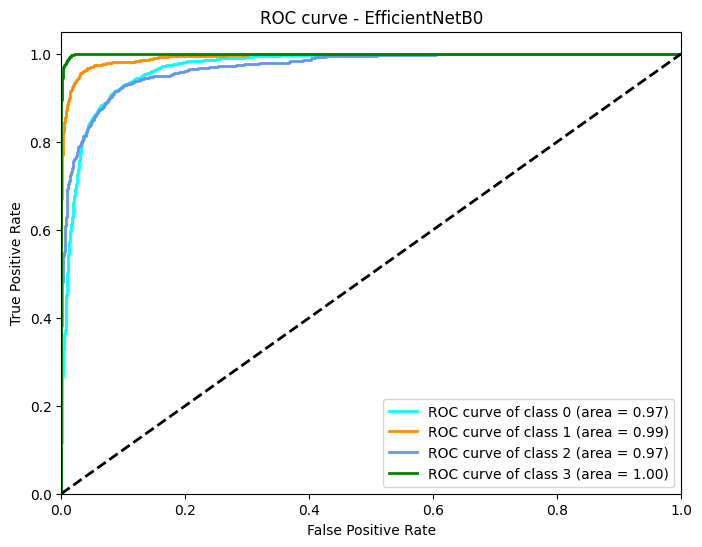

In [ ]:
# One vs rest ROC curves for the models

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def plot_multiclass_roc(y_true, y_pred, model_name, n_classes = 4):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # random predictions
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


y_pred_resnet50_proba = model_resnet50.predict(X_test)
plot_multiclass_roc(y_test, y_pred_resnet50_proba, 'ResNet50')

y_pred_vgg16_proba = model_vgg16.predict(X_test)
plot_multiclass_roc(y_test, y_pred_vgg16_proba, 'VGG16')


y_pred_efficientnet_proba = model_efficientnet.predict(X_test)
plot_multiclass_roc(y_test, y_pred_efficientnet_proba, 'EfficientNetB0')